In [1]:
# use model as ViViT model or slowfast model
import torch
import pandas as pd
import matplotlib.pyplot as plt
from src.dataloader import VideoDataset
from src.utils.sampler import ImbalancedDatasetSampler
from torch.utils.data import DataLoader

/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# video vision transformer model
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Union, Optional
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from pytorch_model_summary import summary

# Module for ViViT
# Residual module
class Residule(nn.Module):
    def __init__(self, fn):
        super(Residule, self).__init__()
        self.fn = fn
    def forward(self, x : torch.Tensor, **kwargs)->torch.Tensor:
        return self.fn(x, **kwargs) + x

# PreNorm module
class PreNorm(nn.Module):
    def __init__(self, dim : int, fn : Union[nn.Module, None]):
        super(PreNorm, self).__init__()
        self.dim = dim
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
    
    def forward(self, x : torch.Tensor, **kwargs)->torch.Tensor:
        return self.fn(self.norm(x), **kwargs)

# FeedForward module
class FeedForward(nn.Module):
    def __init__(self, dim : int, hidden_dim : int, dropout : float = 0.5):
        super(FeedForward, self).__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x : torch.Tensor)->torch.Tensor:
        return self.net(x)

# Attention
class Attention(nn.Module):
    def __init__(self, dim : int, n_heads : int = 8, d_head : int = 64, dropout : float = 0.5):
        super(Attention, self).__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.d_head = d_head
        self.dropout = dropout

        project_out = not (n_heads == 1 and d_head == dim)

        self.inner_dim = d_head * n_heads
        self.scale = d_head ** (-0.5)

        self.to_qkv = nn.Linear(dim, self.inner_dim * 3, bias = False) # q, k, v : (dim, inner_dim) matrix

        self.to_out = nn.Sequential(
            nn.Linear(self.inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x : torch.Tensor)->torch.Tensor:
        b, n, _, h = *x.shape, self.n_heads

        qkv = self.to_qkv(x)
        qkv = torch.chunk(qkv, 3, -1)

        q,k,v = map(lambda t : rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        # obtain attention score
        attn = torch.softmax(dots, dim = -1)

        # multply attention score * value
        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        # rearrange as (b,n,h*d) => n_heads * d_head
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)

        return out

    
class Transformer(nn.Module):
    def __init__(self, dim : int, depth : int, n_heads : int, d_head : int, mlp_dim : int, dropout : float = 0.0):
        super(Transformer, self).__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim=dim, n_heads = n_heads, d_head = d_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim=dim, hidden_dim = mlp_dim, dropout = dropout))
            ]))

    def forward(self, x : torch.Tensor)->torch.Tensor:
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

class ViViT(nn.Module):
    def __init__(
        self, 
        image_size : int, 
        patch_size : int, 
        n_frames : int, 
        dim : int = 192, 
        depth : int = 4, 
        n_heads : int = 3, 
        pool : str = 'cls', 
        in_channels : int = 3, 
        d_head :int = 64, 
        dropout : float = 0.,
        embedd_dropout : float = 0., 
        scale_dim :int = 4, 
        ):
        super(ViViT, self).__init__()
        
        assert pool in {'cls', 'mean'}, 'pool type must be either cls(cls token) or mean(mean pooling)'
        assert image_size % patch_size == 0, "Image dimension(height and width) must be divisible by the patch_size"

        self.image_size = image_size
        self.n_frames = n_frames
        self.in_channels = in_channels

        n_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, n_frames, n_patches + 1, dim))
        self.space_token = nn.Parameter(torch.randn(1, 1, dim))
        self.space_transformer = Transformer(
            dim, depth, n_heads, d_head, dim * scale_dim, dropout
        )

        self.temporal_token = nn.Parameter(torch.randn(1,1,dim))
        self.temporal_transformer = Transformer(
            dim, depth, n_heads, d_head, dim * scale_dim, dropout
        )

        self.dropout = nn.Dropout(embedd_dropout)
        self.pool = pool

        self.mlp = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, 1),
        )

    def forward(self, x : torch.Tensor)->torch.Tensor:

        if x.size()[1] == self.in_channels:
            x = torch.permute(x, (0,2,1,3,4))
            
        x = self.to_patch_embedding(x)
        b, t, n, _ = x.shape
        cls_space_token = repeat(self.space_token, '() n d -> b t n d', b = b, t = t)
        cls_temporal_token = repeat(self.temporal_token, '() n d -> b n d', b = b)

        x = torch.cat((cls_space_token, x), dim = 2)
        x += self.pos_embedding[:,:,:(n+1)]
        x = self.dropout(x)

        x = rearrange(x, 'b t n d -> (b t) n d')
        x = self.space_transformer(x)
        x = rearrange(x[:,0], '(b t) ... -> b t ...', b = b)

        x = torch.cat((cls_temporal_token, x), dim = 1)
        x = self.temporal_transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.mlp(x)
        x = torch.sigmoid(x)

        return x

    def summary(self, device : str = 'cpu', show_input : bool = True, show_hierarchical : bool = True, print_summary : bool = True, show_parent_layers : bool = True)->None:
        sample = torch.zeros((1, self.n_frames, self.in_channels, self.image_size, self.image_size), device = device)
        return summary(self, sample, show_input = show_input, show_hierarchical=show_hierarchical, print_summary = print_summary, show_parent_layers=show_parent_layers)


In [3]:
from typing import Optional, List
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, classification_report

def train_per_epoch(
    train_loader : torch.utils.data.DataLoader, 
    model : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    scheduler : Optional[torch.optim.lr_scheduler._LRScheduler],
    loss_fn : torch.nn.Module,
    device : str = "cpu",
    max_norm_grad : Optional[float] = None
    ):

    model.train()
    model.to(device)

    train_loss = 0
    train_acc = 0

    total_pred = np.array([])
    total_label = np.array([])

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.float().to(device)

        output = model(data).squeeze(dim = 1)

        loss = loss_fn(output, target)

        loss.backward()

        # use gradient clipping
        if max_norm_grad:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm_grad)

        optimizer.step()

        train_loss += loss.item()

        pred = (output > torch.FloatTensor([0.5]).to(device))
        train_acc += pred.eq(target.view_as(pred)).sum().item() / data.size(0) 
        
        total_pred = np.concatenate((total_pred, pred.cpu().numpy().reshape(-1,)))
        total_label = np.concatenate((total_label, target.cpu().numpy().reshape(-1,)))
        
    if scheduler:
        scheduler.step()

    train_loss /= (batch_idx + 1)
    train_acc /= (batch_idx + 1)

    train_f1 = f1_score(total_label, total_pred, average = "macro")

    return train_loss, train_acc, train_f1

def valid_per_epoch(
    valid_loader : torch.utils.data.DataLoader, 
    model : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    loss_fn : torch.nn.Module,
    device : str = "cpu",
    ):

    model.eval()
    model.to(device)
    valid_loss = 0
    valid_acc = 0

    total_pred = np.array([])
    total_label = np.array([])

    for batch_idx, (data, target) in enumerate(valid_loader):
        with torch.no_grad():
            optimizer.zero_grad()
            data = data.to(device)
            target = target.float().to(device)
            output = model(data).squeeze(dim = 1)

            loss = loss_fn(output, target)
    
            valid_loss += loss.item()
            pred = (output >= torch.FloatTensor([0.5]).to(device))
            valid_acc += pred.eq(target.view_as(pred)).sum().item() / data.size(0) 

            total_pred = np.concatenate((total_pred, pred.cpu().numpy().reshape(-1,)))
            total_label = np.concatenate((total_label, target.cpu().numpy().reshape(-1,)))

    valid_loss /= (batch_idx + 1)
    valid_acc /= (batch_idx + 1)

    valid_f1 = f1_score(total_label, total_pred, average = "macro")

    return valid_loss, valid_acc, valid_f1

def train(
    train_loader : torch.utils.data.DataLoader, 
    valid_loader : torch.utils.data.DataLoader,
    model : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    scheduler : Optional[torch.optim.lr_scheduler._LRScheduler],
    loss_fn = None,
    device : str = "cpu",
    num_epoch : int = 64,
    verbose : Optional[int] = 8,
    save_best_only : bool = False,
    save_best_dir : str = "./weights/best.pt",
    save_last_dir : str = "./weights/last.pt",
    max_norm_grad : Optional[float] = None,
    criteria : str = "f1_score"
    ):

    train_loss_list = []
    valid_loss_list = []
    
    train_acc_list = []
    valid_acc_list = []

    train_f1_list = []
    valid_f1_list = []

    best_acc = 0
    best_epoch = 0
    best_f1 = 0
    best_loss = torch.inf

    if loss_fn is None:
        loss_fn = torch.nn.CrossEntropyLoss(reduction = 'mean')

    for epoch in tqdm(range(num_epoch), desc = "training process"):

        train_loss, train_acc, train_f1 = train_per_epoch(
            train_loader, 
            model,
            optimizer,
            scheduler,
            loss_fn,
            device,
            max_norm_grad
        )

        valid_loss, valid_acc, valid_f1 = valid_per_epoch(
            valid_loader, 
            model,
            optimizer,
            loss_fn,
            device 
        )

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

        train_f1_list.append(train_f1)
        valid_f1_list.append(valid_f1)

        if verbose:
            if epoch % verbose == 0:
                print("epoch : {}, train loss : {:.3f}, valid loss : {:.3f}, train acc : {:.3f}, valid acc : {:.3f}, train f1 : {:.3f}, valid f1 : {:.3f}".format(
                    epoch+1, train_loss, valid_loss, train_acc, valid_acc, train_f1, valid_f1
                ))

        # save the best parameters
        if save_best_only:
            if criteria == "acc" and best_acc < valid_acc:
                best_acc = valid_acc
                best_f1 = valid_f1
                best_loss = valid_loss
                best_epoch  = epoch
                torch.save(model.state_dict(), save_best_dir)
            elif criteria == "f1_score" and best_f1 < valid_f1:
                best_acc = valid_acc
                best_f1 = valid_f1
                best_loss = valid_loss
                best_epoch  = epoch
                torch.save(model.state_dict(), save_best_dir)
            elif criteria == "loss" and best_loss > valid_loss:
                best_acc = valid_acc
                best_f1 = valid_f1
                best_loss = valid_loss
                best_epoch  = epoch
                torch.save(model.state_dict(), save_best_dir)

        # save the last parameters
        torch.save(model.state_dict(), save_last_dir)

    # print("\n============ Report ==============\n")
    print("training process finished, best loss : {:.3f} and best acc : {:.3f}, best f1 : {:.3f}, best epoch : {}".format(
        best_loss, best_acc, best_f1, best_epoch
    ))

    return  train_loss_list, train_acc_list, train_f1_list,  valid_loss_list,  valid_acc_list, valid_f1_list


def evaluate(
    test_loader : torch.utils.data.DataLoader, 
    model : torch.nn.Module,
    optimizer : Optional[torch.optim.Optimizer],
    loss_fn = None,
    device : Optional[str] = "cpu",
    save_dir : Optional[str] = None
):
    test_loss = 0
    test_acc = 0
    total_pred = np.array([])
    total_label = np.array([])

    if device is None:
        device = torch.device("cuda:0")

    model.to(device)
    model.eval()

    for idx, (data, target) in enumerate(test_loader):
        with torch.no_grad():
            optimizer.zero_grad()
            data = data.to(device)
            target = target.float().to(device)
            output = model(data).squeeze(dim = 1)

            loss = loss_fn(output, target)
    
            test_loss += loss.item()
            pred = (output > torch.FloatTensor([0.5]).to(device))
            test_acc += pred.eq(target.view_as(pred)).sum().item() / data.size(0) 

            total_pred = np.concatenate((total_pred, pred.cpu().numpy().reshape(-1,)))
            total_label = np.concatenate((total_label, target.cpu().numpy().reshape(-1,)))

    test_loss /= (idx + 1)
    test_acc /= (idx + 1)
    
    test_f1 = f1_score(total_label, total_pred, average = "macro")
    conf_mat = confusion_matrix(total_label,  total_pred)

    plt.figure()
    sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1)[:, None],
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=["disruption", "normal"],
        yticklabels=["disruption", "normal"]
    )

    plt.savefig("./results/confusion_matrix.png")

    print("############### Classification Report ####################")
    print(classification_report(total_label, total_pred, labels = [0,1]))
    print("\n# test acc : {:.2f}, test f1 : {:.2f}, test loss : {:.3f}".format(test_acc, test_f1, test_loss))
    print(conf_mat)

    if save_dir:
        with open(save_dir, 'w') as f:
            f.write(classification_report(total_label, total_pred, labels = [0,1]))
            summary = "\n# test score : {:.2f}, test loss : {:.3f}, test f1 : {:.3f}".format(test_acc, test_loss, test_f1)
            f.write(summary)

    return test_loss, test_acc, test_f1


In [4]:
def compute_focal_loss(inputs:torch.Tensor, gamma:float):
    p = torch.exp(-inputs)
    loss = (1-p) ** gamma * inputs
    return loss.mean()

class FocalLossLDAM(torch.nn.Module):
    def __init__(self, weight : Optional[torch.Tensor] = None, gamma : float = 0.1):
        super(FocalLossLDAM, self).__init__()
        assert gamma >= 0, "gamma should be positive"
        self.gamma = gamma
        self.weight = weight

    def forward(self, input : torch.Tensor, target : torch.Tensor)->torch.Tensor:
        return compute_focal_loss(torch.nn.BCELoss()(input, target), self.gamma)


In [5]:
augmentation_args = {
    "bright_val" : 30,
    "bright_p" : 0.5,
    "contrast_min" : 1,
    "contrast_max" : 1.5,
    "contrast_p" : 0.5,
    "blur_k" : 5,
    "blur_p" : 0.5,
    "flip_p" : 0.5,
    "vertical_ratio" : 0.2,
    "vertical_p" : 0.5,
    "horizontal_ratio" : 0.2,
    "horizontal_p" : 0.5
}

image_size = 224
patch_size = 16

use_focal_loss = True
use_sampler = True

batch_size = 16
lr = 1e-3
clip_len = 21
num_epoch = 4
verbose = 1
gamma = 0.95
save_best_dir = "./weights/ViViT_clip_21_dist_0_best.pt"
save_last_dir = "./weights/ViViT_clip_21_dist_0_last.pt"
save_result_dir = "./results/train_valid_loss_acc_ViViT_clip_21_dist_0.png"
save_test_result = "./results/test_ViViT_clip_21_dist_0.txt"
dataset = "dur0.1_dis0"

# torch device state
print("torch device avaliable : ", torch.cuda.is_available())
print("torch current device : ", torch.cuda.current_device())
print("torch device num : ", torch.cuda.device_count())

# torch cuda initialize and clear cache
torch.cuda.init()
torch.cuda.empty_cache()

# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:" + str(0)
else:
    device = 'cpu'
    
# dataset composition
import os
try:
    path = "./dataset/" + dataset + "/"
    path_disruption = path + "disruption/"
    path_borderline = path + "borderline/"
    path_normal = path + "normal/"

    dir_disruption_list = os.listdir(path_disruption)
    dir_borderline_list = os.listdir(path_borderline)
    dir_normal_list = os.listdir(path_normal)

    print("disruption : ", len(dir_disruption_list))
    print("normal : ", len(dir_normal_list))
    print("borderline : ", len(dir_borderline_list))
except:
    print("video dataset directory is not valid")

if __name__ == "__main__":

    train_data = VideoDataset(dataset = dataset, split = "train", clip_len = clip_len, preprocess = False, augmentation = True, augmentation_args=augmentation_args)
    valid_data = VideoDataset(dataset = dataset, split = "val", clip_len = clip_len, preprocess = False, augmentation=True, augmentation_args=augmentation_args)
    test_data = VideoDataset(dataset = dataset, split = "test", clip_len = clip_len, preprocess = False, augmentation=False)

    if use_sampler:
        train_sampler = ImbalancedDatasetSampler(train_data)
        valid_sampler = ImbalancedDatasetSampler(valid_data)
        test_sampler = None

    else:
        train_sampler = None
        valid_sampler = None
        test_sampler = None
    
    train_loader = DataLoader(train_data, batch_size, sampler=train_sampler, num_workers = 8)
    valid_loader = DataLoader(valid_data, batch_size, sampler=valid_sampler, num_workers = 8)
    test_loader = DataLoader(test_data, batch_size, sampler=test_sampler, num_workers = 8)

    sample_data, sample_label = next(iter(train_loader))

    model = ViViT(
        image_size = image_size,
        patch_size = patch_size,
        n_frames = clip_len,
        dim = 64,
        depth = 4,
        n_heads = 4,
        pool = "cls",
        in_channels = 3,
        d_head = 64,
        dropout = 0.25,
        embedd_dropout=0.25,
        scale_dim = 4
    )

    model.cpu()
    model.to(device)

    model.summary(device, show_input = True, show_hierarchical=False, print_summary=True, show_parent_layers=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay=gamma)
    scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size = 2,
            gamma = gamma
    )
    
    if use_focal_loss:
        loss_fn = FocalLossLDAM(weight = None, gamma = 0.5)
    else: 
        # loss_fn = torch.nn.CrossEntropyLoss(reduction = "mean")
        loss_fn = torch.nn.BCELoss()

    # training process
    # train_loss,  train_acc, train_f1, valid_loss, valid_acc, valid_f1 = train(
    #     train_loader,
    #     valid_loader,
    #     model,
    #     optimizer,
    #     scheduler,
    #     loss_fn,
    #     device,
    #     num_epoch,
    #     verbose,
    #     save_best_only = False,
    #     save_best_dir = save_best_dir,
    #     save_last_dir = save_last_dir,
    #     max_norm_grad = 5.0,
    #     criteria = "f1_score"
    #     )

    # model.load_state_dict(torch.load(save_last_dir))

    # # evaluation process
    # test_loss, test_acc, test_f1 = evaluate(
    #     test_loader,
    #     model,
    #     optimizer,
    #     loss_fn,
    #     device,
    #     save_test_result
    # )

    model.cpu()

torch device avaliable :  True
torch current device :  0
torch device num :  2
video dataset directory is not valid
Number of train videos: 6374
Number of val videos: 1595
Number of test videos: 1994
----------------------------------------------------------------------------
      Layer (type)              Input Shape         Param #     Tr. Param #
       Rearrange-1     [1, 21, 3, 224, 224]               0               0
          Linear-2        [1, 21, 196, 768]          49,216          49,216
         Dropout-3         [1, 21, 197, 64]               0               0
     Transformer-4            [21, 197, 64]         395,904         395,904
     Transformer-5              [1, 22, 64]         395,904         395,904
       LayerNorm-6                  [1, 64]             128             128
          Linear-7                  [1, 64]              65              65
Total params: 841,217
Trainable params: 841,217
Non-trainable params: 0
-------------------------------------------

dataset :  torch.Size([869, 3, 21, 224, 224])
thermal quench : 87.89
current quench : 87.91


ViViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1=16, p2=16)
    (1): Linear(in_features=768, out_features=64, bias=True)
  )
  (space_transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (fn): Attention(
            (to_qkv): Linear(in_features=64, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=64, bias=True)
              (1): Dropout(p=0.25, inplace=False)
            )
          )
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): PreNorm(
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=64, out_features=256, bias=True)
              (1): GELU()
              (2): Dropout(p=0.25, inplace=False)
              (3): Linear(in_features=256, out_features=64, bias=True)
              (4): Dropout(p=0.25, inplace

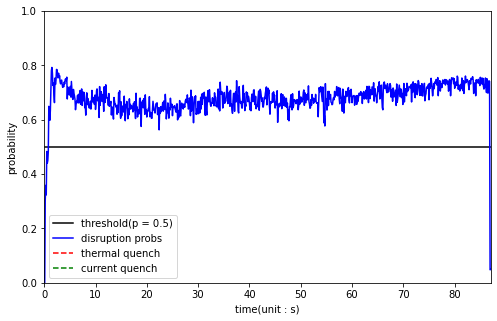

In [8]:
def generate_prob_curve(
    dataset : torch.Tensor, 
    model : torch.nn.Module, 
    batch_size : int = 32, 
    device : str = "cpu", 
    save_dir : Optional[str] = "./results/disruption_probs_curve.png",
    shot_list_dir : Optional[str] = "./dataset/KSTAR_Disruption_Shot_List.csv",
    shot_number : Optional[int] = None,
    clip_len : Optional[int] = None,
    dist_frame : Optional[int] = None,
    use_continuous_frame : bool = True
    ):
    prob_list = []
    video_len = dataset.size(0)

    model.to(device)
    model.eval()

    if video_len >= batch_size:
        batch_rest = video_len % batch_size
            
        for idx in range(int(video_len / batch_size)):
            with torch.no_grad():
                idx_start = batch_size * idx
                idx_end = batch_size * (idx + 1)

                frames = dataset[idx_start : idx_end, :, :, :, :]
                frames = frames.to(device)
                output = model(frames)
            
                prob_list.extend(
                    output.cpu().detach().numpy().reshape(-1,).tolist()
                )
        
        if batch_rest !=0:
            with torch.no_grad():
                idx_start = batch_size * (idx + 1)
                idx_end = idx_start + batch_rest

                frames = dataset[idx_start : idx_end, :, :, :, :]
                frames = frames.to(device)
                output = model(frames)
            
                prob_list.extend(
                    output.cpu().detach().numpy().reshape(-1,).tolist()
                )

    else:
        with torch.no_grad():
            frames = dataset[:, :, :, :, :]
            frames = frames.to(device)
            output = model(frames)
            prob_list.extend(
                output.cpu().detach().numpy().reshape(-1,).tolist()
            )
     
    if shot_list_dir and shot_number:
        shot_list = pd.read_csv(shot_list_dir)
        shot_info = shot_list[shot_list["shot"] == shot_number]
    else:
        shot_list = None
        shot_info = None

    if shot_info is not None:
        t_disrupt = shot_info["tTQend"].values[0]
        t_current = shot_info["tipminf"].values[0]
    else:
        t_disrupt = None
        t_current = None

    if use_continuous_frame:
        interval = 1
        # clip_len + distance만큼 외삽 진행
        prob_list = [0] * (clip_len + dist_frame) + prob_list
    else:
        interval = clip_len
        prob_list = [0] * (1 + int(dist_frame / clip_len)) + prob_list

    if save_dir:
        fps = 210

        time_x = np.arange(1, len(prob_list) + 1) * (1/fps) * interval
        threshold_line = [0.5] * len(time_x)

        plt.figure(figsize = (8,5))
        plt.plot(time_x, threshold_line, 'k', label = "threshold(p = 0.5)")
        plt.plot(time_x, prob_list, 'b-', label = "disruption probs")

        if t_disrupt is not None:
            plt.axvline(x = t_disrupt, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", label = "thermal quench")
            print("thermal quench : {:.2f}".format(t_disrupt))
        
        if t_current is not None:
            plt.axvline(x = t_current, ymin = 0, ymax = 1, color = "green", linestyle = "dashed", label = "current quench")
            print("current quench : {:.2f}".format(t_current))

        plt.ylabel("probability")
        plt.xlabel("time(unit : s)")
        plt.ylim([0,1])
        plt.xlim([0,max(time_x)])
        plt.legend()
        plt.savefig(save_dir)

    return prob_list

from src.utils.utility import video2tensor

video_path = "./dataset/raw_videos/raw_videos/021757tv02.avi"
shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List.csv"
shot_number = 21757

dataset = video2tensor(
    dir = video_path,
    channels  = 3, 
    clip_len  = clip_len, 
    crop_size  = 224,
    resize_width  = 256,
    resize_height = 256,
    use_continuous_frame = False
)

print("dataset : ", dataset.size())

# torch cuda initialize and clear cache
torch.cuda.init()
torch.cuda.empty_cache()

# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:0"
else:
    device = 'cpu'

model = ViViT(
    image_size = image_size,
    patch_size = patch_size,
    n_frames = clip_len,
    dim = 64,
    depth = 4,
    n_heads = 4,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

weight = "./weights/ViViT_clip_21_dist_0_last.pt"
model.load_state_dict(torch.load(weight))

probs = generate_prob_curve(dataset, model, batch_size = 16, device = device, shot_list_dir = shot_list_dir, shot_number = shot_number, clip_len = clip_len, dist_frame = 0, use_continuous_frame = False)
model.cpu()